# 1. SETTINGS

In [49]:
# libraries
import numpy as np
import pandas as pd
from datetime import date

In [50]:
# warnings
import warnings
warnings.filterwarnings("ignore")

In [51]:
# plots
import matplotlib as plt
%matplotlib inline

In [52]:
# pandas options
pd.set_option("display.max_columns", None)

# 2. IMPORT

In [53]:
# import datasets
data = pd.read_csv("../data/prepared/data_basic_1.csv", compression = "gzip")

In [54]:
# check data
print("Dimensions:", data.shape)
data.head()

Dimensions: (111778638, 6)


,PredictionIdx,CustomerIdx,IsinIdx,BuySell,CustomerInterest,Week
0,NaN,0,16471,Buy,0.0,1
1,NaN,0,16471,Buy,0.0,2
2,NaN,0,16471,Buy,0.0,3
3,NaN,0,16471,Buy,0.0,4
4,NaN,0,16471,Buy,0.0,5


# 3. FUNCTIONS TO CREATE FEATURES

In [55]:
### FUNCTION FOR COMPUTING WEEK INDEX
def week_idx(date, end_date):
    return round((end_date - date).dt.days / 7 + 0.4).astype(int)

### RECENCY (TIME SINCE LAST TRADE)

In [56]:
##### FUNCTION TO COMPUTE 6 RECENCY-BASED FEATURES 
# 1) Time since last customer trade with that bond with the same BuySell direction
# 2) Time since last customer trade with that bond with any direction
# 3) Time since last customer trade with any bond with the same BuySell direction
# 4) Time since last customer trade with any bond with any direction
# 5) Time since last trade with that bond by any of the customers with the same BuySell direction
# 6) Time since last trade with that bond by any of the customers

def compute_recency(data):

    tmp = data[data.CustomerInterest == 1]
    
    tmp["PrevWeek"] = tmp.sort_values(by = ["Week"], ascending = True).groupby(["CustomerIdx", "IsinIdx", "BuySell"]).Week.shift(1)
    tmp["CurrWeek"] = tmp.Week

    data = data.merge(tmp, how = "left")

    data["CurrWeek"] = data.groupby(["CustomerIdx", "IsinIdx", "BuySell"]).CurrWeek.fillna(method = "ffill")
    data["PrevWeek"] = data.groupby(["CustomerIdx", "IsinIdx", "BuySell"]).PrevWeek.fillna(method = "bfill")
    data["PrevWeek"][data.PrevWeek.isnull()] = data["CurrWeek"]
    data["PrevWeek"][data.PrevWeek >= data.Week] = None
    
    data["Recency1"] = data["Week"] - data["PrevWeek"]
    data["Recency1"][data.Recency1 <= 0] = None
    del data["PrevWeek"], data["CurrWeek"]

    Recency2 = data.groupby(["CustomerIdx", "IsinIdx", "Week"]).Recency1.min().reset_index()
    Recency2.columns = ["CustomerIdx", "IsinIdx", "Week", "Recency2"]
    data = data.merge(Recency2, how = "left", on = ["CustomerIdx", "IsinIdx", "Week"])
    
    Recency3 = data.groupby(["CustomerIdx", "BuySell", "Week"]).Recency1.min().reset_index()
    Recency3.columns = ["CustomerIdx", "BuySell", "Week", "Recency3"]
    data = data.merge(Recency3, how = "left", on = ["CustomerIdx", "BuySell", "Week"])
    
    Recency4 = data.groupby(["CustomerIdx", "Week"]).Recency1.min().reset_index()
    Recency4.columns = ["CustomerIdx", "Week", "Recency4"]
    data = data.merge(Recency4, how = "left", on = ["CustomerIdx", "Week"])
    
    Recency5 = data.groupby(["IsinIdx", "BuySell", "Week"]).Recency1.min().reset_index()
    Recency5.columns = ["IsinIdx", "BuySell", "Week", "Recency5"]
    data = data.merge(Recency5, how = "left", on = ["IsinIdx", "BuySell", "Week"])
    
    Recency6 = data.groupby(["IsinIdx", "Week"]).Recency1.min().reset_index()
    Recency6.columns = ["IsinIdx", "Week", "Recency6"]
    data = data.merge(Recency6, how = "left", on = ["IsinIdx", "Week"])
    
    #data.Recency1.fillna(data.Recency1.max(), inplace = True)
    #data.Recency2.fillna(data.Recency2.max(), inplace = True)
    #data.Recency3.fillna(data.Recency3.max(), inplace = True)
    #data.Recency4.fillna(data.Recency4.max(), inplace = True)
    #data.Recency5.fillna(data.Recency5.max(), inplace = True)
    #data.Recency6.fillna(data.Recency6.max(), inplace = True)
    
    print("Computed 6 recency features...")
    
    return(data)

### FREQUENCY (TOTAL NUMBER OF TRADES)

In [57]:
##### FUNCTION TO COMPUTE 6 FREQUENCY-BASED FEATURES 
# 1) Number of previous customer trades with that bond with the same BuySell direction
# 2) Number of previous customer trades with that bond with any direction
# 3) Number of previous customer trades with any bond with the same BuySell direction
# 4) Number of previous customer trades with any bond with any direction
# 5) Number of previous trades with that bond by any of the same BuySell direction
# 6) Number of previous trades with that bond by any of the customers
# all frequencies are divided by the number of weeks during which they were observed

def compute_frequency(data):

    tmp = data[data.CustomerInterest == 1]

    tmp["Frequency1"] = tmp.sort_values(by = ["Week"], ascending = True).groupby(["CustomerIdx", "IsinIdx", "BuySell"]).CustomerInterest.cumsum()

    data = data.merge(tmp, how = "left")
    data["Frequency1"] = data.groupby(["CustomerIdx", "IsinIdx", "BuySell"]).Frequency1.fillna(method = "ffill")
    data["Frequency1"][data["CustomerInterest"] == 1] = data["Frequency1"][data["CustomerInterest"] == 1] - 1
    data["Frequency1"].fillna(0, inplace = True)

    Frequency2 = data.groupby(["CustomerIdx", "IsinIdx", "Week"]).Frequency1.sum().reset_index()
    Frequency2.columns = ["CustomerIdx", "IsinIdx", "Week", "Frequency2"]
    data = data.merge(Frequency2, how = "left", on = ["CustomerIdx", "IsinIdx", "Week"])
    
    Frequency3 = data.groupby(["CustomerIdx", "BuySell", "Week"]).Frequency1.sum().reset_index()
    Frequency3.columns = ["CustomerIdx", "BuySell", "Week", "Frequency3"]
    data = data.merge(Frequency3, how = "left", on = ["CustomerIdx", "BuySell", "Week"])

    Frequency4 = data.groupby(["CustomerIdx", "Week"]).Frequency1.sum().reset_index()
    Frequency4.columns = ["CustomerIdx", "Week", "Frequency4"]
    data = data.merge(Frequency4, how = "left", on = ["CustomerIdx", "Week"])

    Frequency5 = data.groupby(["IsinIdx", "Week", "BuySell"]).Frequency1.sum().reset_index()
    Frequency5.columns = ["IsinIdx", "Week", "BuySell", "Frequency5"]
    data = data.merge(Frequency5, how = "left", on = ["IsinIdx", "Week", "BuySell"])
    
    Frequency6 = data.groupby(["IsinIdx", "Week"]).Frequency1.sum().reset_index()
    Frequency6.columns = ["IsinIdx", "Week", "Frequency6"]
    data = data.merge(Frequency6, how = "left", on = ["IsinIdx", "Week"])
    
    div = data.Week - data.Week.min()
    div[div == 0] = 1
    for var in ["Frequency1", "Frequency2", "Frequency3", "Frequency4", "Frequency5", "Frequency6"]:
        data[var] = data[var] / div
    
    print("Computed 6 frequency features...")

    return(data)

### MONTH ID

In [58]:
##### FUNCTION TO COMPUTE MONTH
# 1) Month of each trade

def compute_month(data):

    tmp = pd.read_csv("../data/raw/Trade.csv")
    tmp = tmp[["TradeDateKey"]]

    ### FUNCTION FOR COMPUTING WEEK INDEX
    def week_idx(date, end_date):
        return round((end_date - date).dt.days / 7 + 0.4).astype(int)

    tmp["TradeDateKey"] = pd.to_datetime(tmp["TradeDateKey"], format = '%Y%m%d')
    tmp["Week"] = week_idx(tmp["TradeDateKey"], pd.Timestamp('2018-04-23 00:00:00'))
    tmp["Month"] = tmp["TradeDateKey"].dt.month.astype("object")
    del tmp["TradeDateKey"]
    tmp = tmp.drop_duplicates()

    data = data.merge(tmp, how = "left", on = "Week")
    data["Month"][data.Week == 121] = "4"
    
    print("Computed 1 month feature...")
    
    return data

### INDICATORS OF CUSTOMER INFORMATION

In [59]:
cust  = pd.read_csv("../data/raw/Customer.csv")

In [60]:
# create dummies for customers
cust_dummies = pd.concat([cust.CustomerIdx, pd.get_dummies(cust.Sector), pd.get_dummies(cust.Region)], axis = 1)

### BOND-SPECIFIC FINANCIAL INDICATORS

In [61]:
bond  = pd.read_csv("../data/raw/Isin.csv")

In [62]:
# create bond dummies
bond_dummies = pd.concat([bond.IsinIdx,
                          pd.get_dummies(bond.ActivityGroup), 
                          pd.get_dummies(bond.CompositeRating)], axis = 1)

### MACRO VARIABLES

In [63]:
macro = pd.read_csv("../data/raw/MarketData_Macro.csv")

We have >100 variables here:
- Stock indices (DAX, FTSE100, ...)
- Volatility indices (VSTOXX, VIX, )
- Currency exchange rates (USD <> EUR/CNY/...)
- Inter-bank money lending rate (Money Market) 3-month for each currency 
- Mid- to long-term swaps (2-10 years). TODO: Unsure of the effect on bond trades

In [64]:
# descriptive stats
macro.columns.tolist()[0:15]

['DateKey',
 'SSE',
 'DAX',
 'EUROSTOXX',
 'VSTOXX',
 'FTSE100',
 'HSI',
 'NIKKEI',
 'DOWJONES_INDU',
 'SP500',
 'VIX',
 'FX_USD.ARS',
 'FX_USD.AUD',
 'FX_USD.BRL',
 'FX_USD.CAD']

Heuristically fill missing values with the previous value or 2xprevious value. If still missing, fill values with the following or 2xfollowing value

In [65]:
macro = macro.fillna(macro.shift(1)).fillna(macro.shift(2)).fillna(macro.shift(-1)).fillna(macro.shift(-2))

In [66]:
# convert dates
macro["DateKey"] = pd.to_datetime(macro["DateKey"], format = '%Y%m%d')

In [67]:
### FUNCTION FOR COMPUTING WEEK INDEX
def week_idx(date, end_date):
    return round((end_date - date).dt.days / 7 + 0.4).astype(int)

# add week index
macro["Week"] = week_idx(macro["DateKey"], pd.Timestamp('2018-04-23 00:00:00'))
macro["Week"] = macro["Week"].max() + 1 - macro["Week"]

Aggregate the macro values by week. 

TODO: We could also take the lag first and then aggregate, not sure what makes more sense (JH).

In [68]:
macro = macro.groupby(["Week"]).agg("mean")

We are interested in the change in the macro variable compared to the previous date, I think, to check if e.g. the currency value went up or down

In [69]:
# Replace missing lag for first week with 0
macro_diff1 = (macro - macro.shift(1)).fillna(0)
#macro_diff1.columns = [x + "_diff1" for x in macro_diff1.columns]

TODO: I think it makes sense to create a common variable e.g. "currency trend" that relates to the specific currency of the bond and/or holder.

In [70]:
fx_diff1 = macro_diff1.filter(like = "FX", axis = 1)

In [71]:
fx_diff1.columns

Index(['FX_USD.ARS', 'FX_USD.AUD', 'FX_USD.BRL', 'FX_USD.CAD', 'FX_USD.CHF',
       'FX_USD.CNO', 'FX_USD.CNY', 'FX_USD.EUR', 'FX_USD.GBP', 'FX_USD.HKD',
       'FX_USD.IDR', 'FX_USD.JPY', 'FX_USD.NOK', 'FX_USD.SGD', 'FX_USD.TRY',
       'FX_USD.ZAR'],
      dtype='object')

In [72]:
fx_diff1["USD"] = 1
#fx_diff1["USD_diff1"] = 1

In [73]:
fx_diff1 = fx_diff1.reset_index().melt(id_vars = "Week", var_name = "Currency", value_name = "Currency_trend")

In [74]:
fx_diff1.Currency = fx_diff1.Currency.str[-3:]

The currency data 'fx' can be merged into the bond data

In [75]:
bond.Currency.unique()

array(['USD', 'ARS', 'ARO', 'EUR', 'AUD', 'GBP', 'CAD', 'CHF', 'CNY',
       'CNO', 'CNH', 'HKD', 'ITL', 'JPY', 'SGD', 'BRL', 'IDR', 'FRF',
       'DEM', 'TRY', 'ZAR', 'NOK', 'INR'], dtype=object)

In [76]:
fx_diff1.Currency.unique()

array(['ARS', 'AUD', 'BRL', 'CAD', 'CHF', 'CNO', 'CNY', 'EUR', 'GBP',
       'HKD', 'IDR', 'JPY', 'NOK', 'SGD', 'TRY', 'ZAR', 'USD'],
      dtype=object)

# 4. COMPUTING FEATURES

### MERGE FEATURES FROM NIKITA

In [77]:
# compute past features
data = compute_recency(data)
data = compute_frequency(data)

Computed 6 recency features...
Computed 6 frequency features...


In [78]:
# compute months
data = compute_month(data)

Computed 1 month feature...


In [ ]:
# compute BuySell dummy
data["Buy"] = 0
data["Buy"][data.BuySell == "Buy"] = 1 

### MERGE FEATURES FROM JOHANNES

In [ ]:
# merge customer dummies
data = data.merge(cust_dummies, on = "CustomerIdx", how = "left")

In [ ]:
# merge bond dummies
bond_dummies = bond_dummies[['IsinIdx', 'FLOW G10', 'FLOW LOCAL MARKET', 'SAS & COVERED BONDS', 'NR']]
data = data.merge(bond_dummies, on = "IsinIdx", how = "left")

In [ ]:
# merge macro variables
data = data.merge(bond[["IsinIdx", "Currency"]], on = "IsinIdx")
data = data.merge(fx_diff1, how = 'left', on = ["Week","Currency"])

# there are a few weird currencies (or typos?) for which we don't have information, e.g. CNH. These need to be imputed
data[fx_diff1.columns] = data[fx_diff1.columns].fillna(0)
data.drop("Currency", axis = 1, inplace = True)

In [ ]:
# merge exchange rates
data = data.merge(macro_diff1.reset_index(), on = "Week", how = "left")

### MERGE FEATURES FROM ALISA

In [ ]:
# load bond data
bond_stat = pd.read_csv("../data/prepared/bondstat1_AK")

# merge bond data
data = data.merge(bond_stat[["IsinIdx", "MeanPrice", "StdPrice", "MeanYield",
      "StdYield", "MeanZScore", "StdZScore", "YieldMarktDelta",
      "ZScoreMarktDelta"]], how = "left", on = "IsinIdx")

# 5. CORRECT AND EXPORT

In [ ]:
# clear memory
del bond_stat, macro_diff1, fx_diff1, bond, bond_dummies, cust_dummies

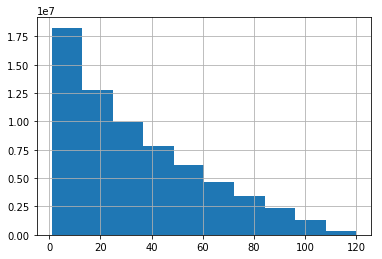

In [79]:
# check recency distribution
data.Recency1.hist()

In [80]:
# remove first X weeks
data = data[data.Week > 50]

In [81]:
# check dimensions
print(data.shape)

(74680678, 19)


In [82]:
# remove data with too high Recency2
data = data.loc[data.Recency2 < 27]

In [83]:
# check NA
nas = data.isnull().sum()
nas[nas > 0]

PredictionIdx       26650982
CustomerInterest      484758
Recency1             1868028
Recency3                4114
Recency5               16828
dtype: int64

In [85]:
# export CSV
data.to_csv("../data/prepared/data_v7_50_basic.csv", index = False, compression = "gzip")